In [1]:
#Autores: Daniel Castillo, Karla Salas con ayuda del profesor Mijangos
from os import listdir
from os.path import isfile, join
#Para ver las palabras
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
# nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from sklearn.model_selection import train_test_split #particiones
from nltk.corpus import stopwords #Listas de stopwords
from nltk.tokenize import word_tokenize, sent_tokenize #Tokens
import re #regex
from itertools import chain #bigramas
import numpy as np
from operator import itemgetter
import pickle # Guardar objetos
from tqdm import tqdm #Medir el progreso del entrenamiento

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Limpiamos y tokenizamos
(Tomamos el código de la práctica anterior)

Tokenizamos por oración y por palabra, ya que nos interesa medir la probabilidad de transitar de una palabra a otra y no por subpalabras (BPE), para intentar, más adelante, responder con una oración dada una entrada.

In [2]:
def get_txt(path):
    """
    Regresa una lista con el contenido de todos los archivos de un directorio

    Args:
        path (str): ruta de la carpeta
    """
    text = []
    onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]
    
    for file in onlyfiles:
        with open(path+"/"+file, 'rb') as f:
            text.append(f.read().decode('utf-8', 'replace'))
    return text

# Guardamos cada película en un diccionario
# cada entrada del diccionario es una lista con las peliculas leídas
movies = {}
movies["Pride & Prejudice"] = get_txt("../corpus/Pride & Prejudice")
movies["Marvel"] = get_txt("../corpus/Marvel")
movies["Christopher Nolan"] = get_txt("../corpus/Christopher Nolan")

In [3]:
# tokens que necesitan ser limpiados del corpus y que no
# se encuentran en la lista de stopwords
more = ["_","-","'ve", "'ll", "'t", "'s", "'re", "'", "'m", "'d", "n't", "oh", "hey", "yeah","okay", "mr.", "miss", "mrs."]
stopwords_list = stopwords.words('english') + more

def get_tokens_clean(text):
    '''
    Genera los tokens de una cadena y los limpia
    (quita símbolos raros y stopwords)
    
    Args:
        text (str): cadena
    '''
    tokens = word_tokenize(text)
    clean = []
    pattern = r'[^a-z0-9\s]'
    for w in tokens:
        #quita stopwords y convierte a minúsculas
        w = re.sub(pattern,'', w.lower())
        if w not in stopwords_list and w != '':
            if  w == "na": #Para juntar gon na, wan na, etc.
                clean[-1] += w
            else:
                clean.append(w)

    return clean

In [4]:
def merge_movies(col):
    '''
    Mezcla el corpus de cada película en una entrada del
    diccionario movies en un solo corpus, 
    guarda los diálogos por línea tokenizados y limpios

    Args:
        col (dic): Diccionario con los diálogos
    '''
    corpus = []
    #Iteramos sobre las películas
    for movie in tqdm(col):
        for text in movies[movie]:
            #Cada texto se guarda por oraciones (contexto)
            corpus += [get_tokens_clean(s) for s in sent_tokenize(text)]
    return corpus

all_movies = merge_movies(movies)

100%|██████████| 3/3 [00:05<00:00,  1.90s/it]


In [5]:
#Particiones train, test (30%)
train, test = train_test_split(all_movies, test_size=0.3)
print('Número de cadenas train:',len(train))
print('Número de cadenas test:',len(test))

Número de cadenas train: 36479
Número de cadenas test: 15634


Quitamos las hápax: palabras que solo aparecen una vez en el corpus

In [6]:
def delete_hapax(corpus):
    '''
    Reemplaza las hapax en el corpus por la cadena '<oov>'

    Args:
        corpus (list(list)): corpus tokenizado por oración y palabra
    '''
    new_corpus = []
    #Obtenemos las frecuencias de las palabras
    frequences = Counter( chain(*[sentence for sentence in corpus]) )
    for sentence in tqdm(corpus):
      new_sent = []
      for word in sentence:
        new_sent.append(#reemplazamos
          '<oov>' if frequences[word] == 1 else word
        )
      new_corpus.append(new_sent)
    return new_corpus

all_movies = delete_hapax(all_movies)

100%|██████████| 52113/52113 [00:00<00:00, 1302896.14it/s]


## Vocabulario (indexado)
Obtenemos los pares de entrenamiento a partir de contextos, bigramas.

In [7]:
def get_words_and_indexes(corpus):
    '''
    Genera el vocabulario del corpus y le asigna 
    un índice a cada palabra

    Args:
        corpus (list(list)): corpus tokenizado por oración y palabra
    '''
    # Generamos el vocabulario
    words_to_index = list(Counter( chain(*[sentence for sentence in corpus]) ).keys())
    # Agregamos etiquetas de inicio y fin al diccionario
    words_to_index.append('<BOS>')
    words_to_index.append('<EOS>')
    # Índices para cada palabra
    words_to_index = dict(zip(words_to_index, range(0, len(words_to_index) - 1)))
    # A cada oración se le agrega la etiqueta BOS al inicio y EOS al final
    new_corpus = [[len(words_to_index) - 2] + [words_to_index[t] for t in text] + [len(words_to_index) - 1] for text in corpus]
    return words_to_index, new_corpus

def get_bigrams(corpus):
    '''
    Genera los bigramas por oración dado un corpus

    Args:
        corpus (list(list)): corpus tokenizado por oración y palabra
    '''
    bigrams = list(chain(*[zip(cad,cad[1:]) for cad in corpus]))
    return bigrams

# vocabulario de todo el corpus
word_to_index, new_corpus = get_words_and_indexes(all_movies)
# Creamos conjuntos de train y test
train, test = train_test_split(new_corpus, test_size=0.3)
# Obtenemos bigramas
bigrams_train = get_bigrams(train)
bigrams_test = get_bigrams(test)

print('Bigramas de train: {}'.format(len(bigrams_train)))
print('Bigramas de test: {}'.format(len(bigrams_test)))

Bigramas de train: 162653
Bigramas de test: 69645


# Red de Bengios

Red propuesta por Bengios, de tipo FeedForward con una arquitectura constituida por:
 - Una capa de embedding (representación númerica de las palabras)
 - Una capa oculta con activación tanh
 - Una capa de salida con activación Softmax para obtener las probabilidades de transición.

<p align="center">
  <img src="img/RedBengio.png" alt="Red Bengio"/>
</p>


In [8]:
class Bengio:
    '''
    Aplica la arquitectura de Bengios
    
    Args:
        bigrams (list): Lista de bigramas por oración en el corpus
        voc (dic): Diccionario de palabras con su índice asociado
        dim (int): Unidades ocultas
        nn_hdim (int): Unidades en la segunda capa
    '''
    def __init__(self, bigrams, voc, dim, nn_hdim):
        np.random.seed(0)
        self.bigrams = bigrams
        self.voc = voc
        # unidades de la capa oculta
        self.dim = dim
        # unidades de la segunda capa
        self.nn_hdim = nn_hdim
        N = len(voc)
        #Embedding (este vector se guarda para la siguiente tarea)
        self.C = np.random.randn(dim, N) / np.sqrt(N)
        #U (a |V | × h matrix) - hidden-to-output weights
        self.U = np.random.randn(nn_hdim, dim) / np.sqrt(dim)
        self.b = np.zeros((1, self.nn_hdim)) #bias
        # W (a |V | × (n − 1)m matrix) word features to output weights
        self.W = np.random.randn(N, nn_hdim) / np.sqrt(nn_hdim)
        self.c = np.zeros((1, N))
    
    def train(self, its, eta):
        '''
        Entrena la red de Bengios
        Obtiene la probabilidad de transitar de una palabra a otra

        Args:
            its (int): Iteraciones
            eta (int): radio de aprendizaje
        '''
        for i in tqdm(range(0,its)):
            for ex in self.bigrams:
                #Forward
                f, a = self.forward(ex[0])
                #Backward, pasos descritos en el paper
                #Variable de salida, (a).1
                d_out = f
                d_out[ex[1]] -= 1
                #Variable para la capa oculta
                d_tanh = (1-a**2)*np.dot(self.W.T,d_out)
                #Variable de embedding
                d_emb = np.dot(self.U.T, d_tanh)
                #Actualizacion de salida
                self.W -= eta*np.outer(d_out,a)
                #Actualiza bias de salida
                self.c -= eta*d_out #[j]
                #Actualizacion de capa oculta
                self.U -= eta*np.outer(d_tanh,self.C.T[ex[0]])
                #Actualiza bias
                self.b -= eta*d_tanh
                #Actualizacion de embedding
                self.C.T[ex[0]] -= eta*d_emb

    def forward(self, x): 
        '''
        Etapa forward de la red 
        sirve para entrenar y evaluar el modelo

        Args:
            x (str): Palabra a calcular la probabilidad dado un contexto
        '''  
        #Embedimiento
        x = self.C.T[x] #x(k) ← C(wt−k)
        #capa oculta
        #a ← tanh(Hx + d)
        a = np.tanh(np.dot(self.U, x) + self.b)[0]
        #salida
        # p_j ← e**(a.U + b_j) 
        # if (direct connections) e**(e**(a.U + b_j) + x.W_j)
        out = np.exp(np.dot(self.W, a) + self.c)[0]
        #Softmax
        # Normalize the probabilities
        self.p = out/out.sum(0)
        return self.p, a

    def plot_words(self, ids):
        '''
        Muestra los embedings utilizando PCA

        Args:
            ids (int): valor númerico de la palabra
        '''
        Z = PCA(2).fit_transform(self.C.T[:-2])
        r=0
        plt.xticks(np.arange(-2, 2, 0.3))
        plt.yticks(np.arange(-2, 2, 0.3))
        plt.scatter(Z[:,0],Z[:,1], marker='.')
        for label,x,y in zip(ids, Z[:,0], Z[:,1]):
            plt.annotate(label, xy=(x,y), xytext=(-1,1), 
                         textcoords='offset points', 
                         ha='center', va='bottom')
            r+=1
        plt.show()

    def prob_sentence(self, sentence):
        '''
        Obtenemos la probabilidad de la oración

        Args:
            sentence (list): lista de las palabras que componen la oración
        '''
        #Obtenemos los bigramas de la cadena de evaluacion
        bigrams = list(zip(sentence,sentence[1:]))
        p = 1
        #Multiplicamos por las probabilidades de los bigramas dado el modelo
        for gram1, gram2 in bigrams:
            #Obtiene las probabilidades de transición
            try:
                prev_prob = self.forward(gram1)[0]
            except:
                prev_prob = self.forward(word_to_index['<oov>'])[0]

            try:
                p *= prev_prob[gram2]
            except:
                p *= prev_prob[word_to_index['<oov>']]
                
        return p 

    def get_entropy(self, test_data):
        '''
        Obtenemos la entropia promedio del modelo

        Args:
            test_data (list): conjunto de prueba tokenizado
        '''
        H = 0.0
        # calculamos entropia como el promedio de las probabilidades de cada oración
        for sentence in tqdm(test_data):
            #Probabilidad de la cadena
            p_cad = self.prob_sentence(sentence)
            #Longitud de la cadena
            M = len(sentence)
            #Obtenemos la entropía cruzada de la cadena
            if p_cad != 0:
                H -= (1./M)*(np.log(p_cad)/np.log(2))

        return H/len(test_data)
    
    def test(self, test):
        '''
        Probamos el modelo

        Args:
            test (list): conjunto de prueba tokenizado
        '''
        entropy = self.get_entropy(test)
        perplexity = 2**entropy
        return entropy, perplexity

    def save_embedings(self, path):
        '''
        Guardamos en diccionario (palabra: embeding) en un
        archivo

        Args:
            path (str): ruta para guardar el archivo
        '''
        embedings = {}
        for word in self.voc.keys():
            embedings[word] = self.C.T[self.voc[word]]

        pickle.dump(embedings, open(path, 'wb'))

    def save_model(self, path):
        """
        Para guardar el modelo ya entrenado en un archivo

        Args:
            path (str): ruta para guardar el archivo
        """
        pickle.dump(self, open(path, 'wb'))

## Entrenamiento

In [9]:
bigrams_train_10, _ = train_test_split(bigrams_train, test_size=0.9)
bengio = Bengio(bigrams_train_10, word_to_index, 254, 128)
bengio.train(20, 0.1)

100%|██████████| 20/20 [54:34<00:00, 163.74s/it]


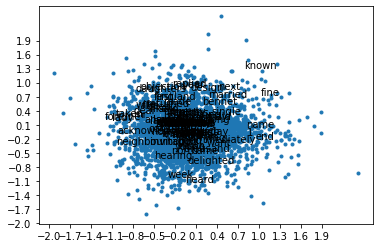

In [10]:
label = [w[0] for w in sorted(list(word_to_index.items())[:100], key=itemgetter(1))]
bengio.plot_words(label)

Evaluamos el modelo

In [11]:
entropy, perplexity =  bengio.test(test[:1000])
print('Entropy: {}'.format(entropy))
print('Perplexity: {}'.format(perplexity))

100%|██████████| 1000/1000 [00:01<00:00, 774.59it/s]

Entropy: 9.29426577135724
Perplexity: 627.8454985552166


Guardamos los embedings

In [13]:
bengio.save_embedings('./model/embedings.pkl') #Guardamos
# Comprobamos que se guardó correctamente
embedings = pickle.load(open('./model/embedings.pkl', 'rb'))
print(embedings['stephen'])

[ 0.0504375   0.04204342 -0.00066883  0.05583031 -0.05504821 -0.04661325
 -0.03567859  0.02856636 -0.07742847 -0.08115211 -0.00255162 -0.02371278
 -0.01118197  0.06105471 -0.06254846  0.01458872  0.03855344 -0.03182118
 -0.10369294  0.12573338 -0.01588852  0.00361127 -0.00324225 -0.0393842
 -0.00609624  0.00038337 -0.02002499 -0.04346576 -0.01816284 -0.02890435
 -0.1023391  -0.07257143  0.00223933  0.04288617  0.06092228 -0.03227182
  0.01773254  0.03503374 -0.04933452  0.02959524  0.02351907  0.06661715
  0.06895565  0.0518188   0.00208171 -0.00443749  0.05178246  0.03788481
  0.04473546  0.04646946 -0.0391963  -0.03587902 -0.04745228  0.04515332
  0.01138696 -0.05141409  0.03311824 -0.05494937 -0.0183703   0.03279078
  0.03324758 -0.00615126 -0.06551508 -0.08074445 -0.04497633 -0.04473423
 -0.00987398 -0.0330098   0.00537228 -0.00768853  0.10578091  0.09539409
  0.01235125 -0.03502969  0.05489088 -0.00370614  0.10468272 -0.04961365
  0.05047221  0.02368864  0.03338356 -0.09449841 -0.

Guardamos la red

In [14]:
bengio.save_model('./model/model.pkl') #Guardamos
# Comprobamos que se guardó correctamente
bengio_new = pickle.load(open('./model/model.pkl', 'rb'))

entropy, perplexity =  bengio.test(test[:1000])
print('Entropy: {}'.format(entropy))
print('Perplexity: {}'.format(perplexity))

100%|██████████| 1000/1000 [00:01<00:00, 713.89it/s]

Entropy: 9.29426577135724
Perplexity: 627.8454985552166
